# Education ROI and Graduate Outcomes Analysis in Canada
This analysis explores the return on investment (ROI) of postsecondary education in Canada by field of study, integrating education, income, and labour market data. Our goal is to mainly inform students about the long-term value of different educational paths at undergraduate level—helping them to make data-driven decisions about their fututre. Additionally, the analys would offer insights for policymakers to align educational offerings with labour market demand.

We aim to answer key questions:
* Which fields offer the best financial return relative to tuition?
* Are some fields oversaturated with graduates relative to employment opportunities?
* Do tuition costs reflect real-world outcomes like income or job stability?

Ultimately, this project would help identify high-value programs, highlight potential risks (like education bubbles), and support better policy and personal decision-making.

In [31]:
import pandas as pd
import numpy as np
from visuals import plots

import importlib
importlib.reload(plots)

<module 'visuals.plots' from 'C:\\Users\\ngoum\\Documents\\coding\\data_projects\\graduate-roi-canada\\visuals\\plots.py'>

## 1. Load Datasets and Merge Datasets

In [2]:
ed_outcomes_data = pd.read_csv("data/postsecondary_field_outcomes.csv")

In [3]:
labour_snapshots = pd.read_csv("data/labour_market_snapshot.csv")

Merge Datasets

In [4]:
ed_outcomes_data = ed_outcomes_data.rename(columns={
    "Nearest Census Year": "Census Year"
})

In [5]:
data = ed_outcomes_data.merge(
    labour_snapshots,
    on=["Field of study", "Census Year"],
    how="left"
)

We concentrate on undergraduate education, as this is the level at which most individuals make critical decisions about field of study, and where questions around the return on investment (ROI) in education are most common. Additionally, the majority of the population does not pursue graduate studies, making undergraduate outcomes the most broadly relevant.

In [6]:
data = data[data["Education Level Group"] == "Undergraduate"]

To accurately calculate ROI, we need a realistic estimate of the total cost of an undergraduate degree. Instead of using a single semester’s tuition, we computed a 4-year rolling sum per field of study to reflect the full tuition paid over a typical program. This provides a more accurate and meaningful measure of educational investment.

In [7]:
data = data.sort_values(["Field of study", "Year"])

In [8]:
# Compute annual tuition
annual_tuition = data["Tuition"] * 2

# Compute cummulative tuition cost over 4 years
data["Tuition (4Y)"] = (
    data.groupby("Field of study")["Tuition"]
        .rolling(window=4, min_periods=4)
        .sum()
        .reset_index(level=0, drop=True)
)

Our primary analysis focuses on the period from 2012 to 2022, aligning with the most recent available census labour force data and median income statistics. 

In [9]:
data = data[data["Year"].between(2012,2022)]

For easy visualization, we simplify or abbreviate the fields of studies names

In [10]:
field_name_mapping = {
    'Architecture & Engineering': 'Arch & Eng',
    'Arts and Humanities': 'Arts & Hum',
    'Business & Public Admin': 'Bus & Admin',
    'Education': 'Education',
    'Health': 'Health',
    'Mathematics & CIS': 'Math & CIS',
    'Social Sciences and Law': 'SocSci & Law'
}

data["Field (Long)"] = data["Field of study"].copy()
data["Field of study"] = data["Field of study"].map(field_name_mapping)

## 2. Compute Derived Metrics
To evaluate the value and labour outcomes of each field of study, we compute a series of derived metrics. These indicators capture the relationship between tuition costs, graduate numbers, employment statistics, and income, allowing us to assess ROI, market saturation, and growth trends across disciplines.

| Metric                  | Definition                         | Why It Matters                              |
|-------------------------|------------------------------------|---------------------------------------------|
| ROI                     | Median Income ÷ Cumulative Tuition | Core value proposition for students         |
| Graduate Share          | % of grads by field                | Reveals popularity and education trends     |
| Graduate Growth Rate    | Year-over-year % change            | Tracks student demand over time             |
| Tuition Inflation       | Year-over-year tuition change      | Flags rising costs for students             |
| Employment Stability Index (ESI) | Employment rate ÷ Participation rate | Measures employment stability and security |

#### ROI (Return on Investment)
Measures return on investment for education — how much income is earned per tuition dollar. A higher ROI indicates better returns on educational investment. This metric is a proxy for [Cost-Benefit Analysis (CBA)](https://en.wikipedia.org/wiki/Cost%E2%80%93benefit_analysis).

In [11]:
data["ROI"] = np.nan
data["ROI"] = data["Median income"] / data["Tuition (4Y)"]

In [12]:
data["Saturation Index"] = data["Graduates (5Y)"] / (data["Employed (25%)"] * 4)

#### Graduate Share (%)
Shows what portion of total graduates (in a year) each field contributes. Highlights dominant vs niche fields in education supply.

In [13]:
data["Graduate Share (%)"] = data["Graduates"] / data.groupby("Year")["Graduates"].transform("sum") * 100

#### Graduate Growth Rate
Tracks year-over-year change in the number of graduates per fields. This highlights emerging or shrinking academic fields. High growth + low ROI can indicate a “bubble,” while low growth + high ROI may signal underinvestment.

In [14]:
data["Graduate Growth Rate (%)"] = data.groupby("Field of study")["Graduates"].pct_change() * 100

#### Tuition Growth/Inflation (%)
Tracks affordability over time. High growth erodes ROI unless income increases faster. This metric is tracked by Statistics Canada, OECD, and institutional budget planning.

In [15]:
data["Tuition Inflation (%)"] = data.groupby("Field of study")["Tuition"].pct_change() * 100

#### Employment Stability Index (ESI)
The Employment Stability Index (ESI) is a quick indicator of how stable and secure employment is for graduates of a particular field. A higher ESI means graduates are more likely to be employed and less likely to face joblessness. It reflects both job availability and resilience to unemployment.
* ESI ≈ 1.0 → Nearly everyone in the labor force has a job (very stable)
* ESI < 0.9 → A growing portion of the labor force is unemployed (less stable)

In [16]:
data["ESI"] = data["Employment rate"] / (data["Participation rate"] + 1e-8)

In [17]:
f'ESI range: {data["ESI"].min():.3f} - {data["ESI"].max():.3f}'

'ESI range: 0.896 - 0.971'

## 3. Data Analysis

### 3.1. Descriptive Statistics

In [19]:
ignored_cols = ["Field of study", "Census Year", "Education"]

In [20]:
data.drop(columns=ignored_cols).describe()

,Year,Graduates,Graduates (5Y),Tuition,Median income,Participation rate,Employment rate,Unemployment rate,Employed (25%),Tuition (4Y),ROI,Saturation Index,Graduate Share (%),Graduate Growth Rate (%),Tuition Inflation (%),ESI
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000,70.000000,70.000000,77.000000
mean,2017.000000,23789.571429,56455.168831,7574.492290,52714.610390,75.804156,71.070779,6.247662,1.127068e+06,29178.663746,1.905596,0.015625,14.285714,2.240881,2.203872,0.937520
std,3.183014,12728.493611,29153.410172,2200.132461,10242.913429,5.605201,5.524490,1.880865,9.076018e+05,8388.670824,0.509494,0.007259,7.619671,6.757238,3.289019,0.018816
min,2012.000000,4140.000000,11235.000000,4547.127646,30700.000000,62.190000,59.170000,2.900000,2.070650e+05,16671.027778,1.071845,0.003216,2.671054,-27.593880,-6.912568,0.895895
25%,2014.000000,14877.000000,35031.000000,6107.176587,45900.000000,71.410000,67.460000,5.210000,5.653800e+05,23780.636905,1.470770,0.009824,9.165173,-1.486344,1.234475,0.922647
50%,2017.000000,20523.000000,49728.000000,7109.821958,55100.000000,76.520000,70.260000,5.970000,8.769600e+05,27706.724603,1.882157,0.015229,12.012917,2.262669,2.798211,0.940401
75%,2020.000000,39849.000000,90195.000000,8437.140542,59300.000000,79.850000,76.210000,7.730000,1.416630e+06,31668.142196,2.253952,0.022310,24.664515,5.598580,3.691359,0.947854
max,2022.000000,46224.000000,107520.000000,13529.646825,73200.000000,84.430000,80.170000,10.400000,3.804445e+06,51193.229497,3.071196,0.032674,26.332867,18.600531,14.285714,0.970922


### 3.2. Education Landscape Overview
This section provides a snapshot of the distribution of graduates across fields of study at the undergraduate level. The goal is to understand which disciplines are the most popular among students and how graduate output is spread across fields.

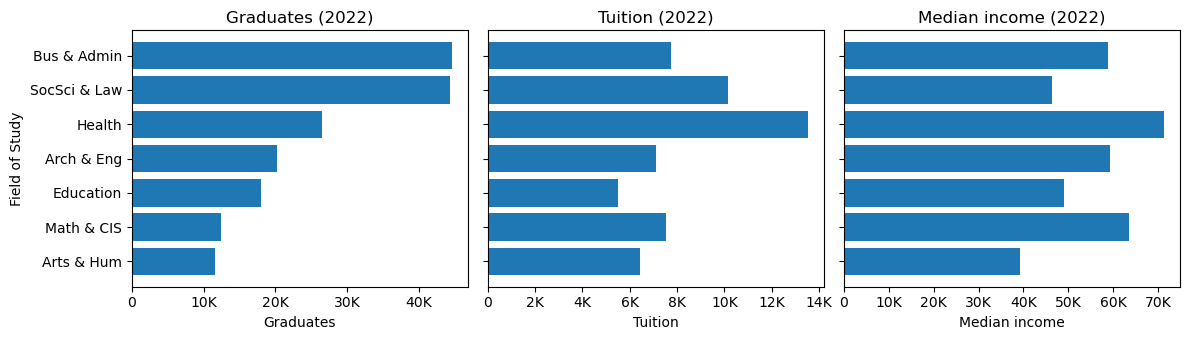

In [21]:
plots.plot_snapshot_metrics(data)

In 2022, **Business & Public Administration** and **Social Sciences & Law** dominated undergraduate education, each producing roughly **25% of all graduates**. Meanwhile, **Health** accounted for a **smaller share (15%)** but led all fields in both tuition costs and median income, suggesting a **high-cost, high-reward dynamic**. Fields like **Arts & Humanities** and **Education** had relatively low tuition, but also reported the lowest median incomes, highlighting potential **concerns around economic return**. **Mathematics & Computer Science** stood out with a **strong income-to-tuition ratio**, suggesting efficient value for students despite moderate enrollment.

### 3.3. Value Analysis (ROI, Income, Tuition)
In this section, we identify which undergraduate fields offer the best financial return, affordability, and value relative to tuition, using ROI, income, tuition, and graduate share.

To ensure a balance between recency and stability, we averaged key metrics over the three most recent years (2020–2022). This approach smooths out short-term fluctuations while still reflecting current tuition costs, income levels, and employment outcomes relevant to today’s students. It would provide a more reliable basis for comparing fields than using a single year, without diluting the insight with older, potentially outdated data.

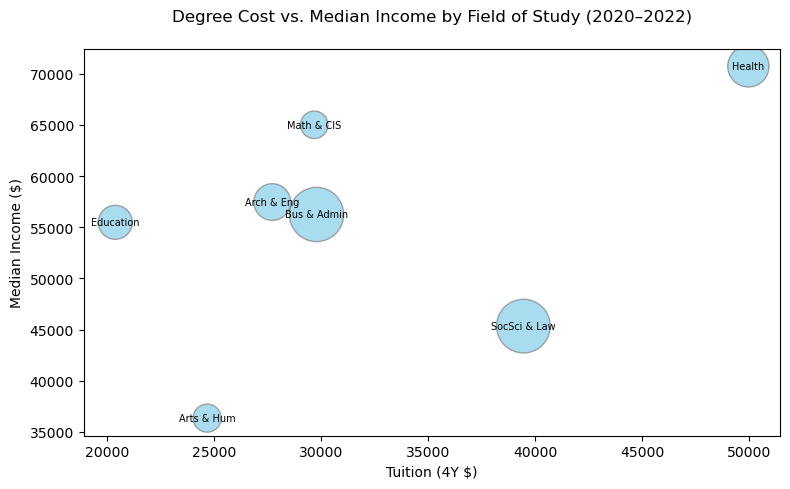

In [22]:
plots.plot_income_vs_tuition_bubble(data, height=5, width=8, bubble_size=60)

The scatter plot reveals clear differences in the cost-effectiveness of undergraduate fields.
* **Education and Math & CIS** stand out as **high-value fields**, offering strong median incomes relative to modest tuition costs.
* **Health** has the highest tuition but also the highest income, indicating a high-cost, high-return model.
* **Arts & Humanities** and **Social Sciences & Law** exhibit lower median incomes despite moderate to high tuition, suggesting a **weaker return on investment**.
* **Business & Admin** and **SocSci & Law** account for nearly **half of all graduates**, yet neither delivers standout income-to-cost ratios—suggesting potential concerns about oversupply in fields with moderate economic return.

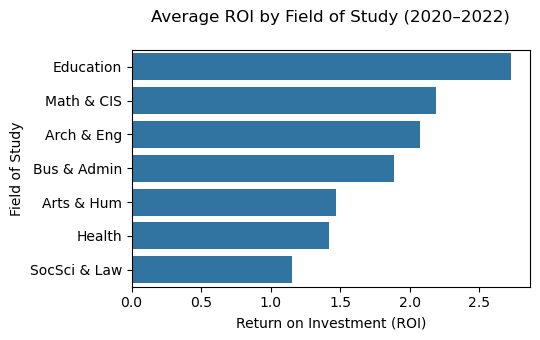

In [23]:
plots.plot_roi_by_field(data, height=3.5, width=5.5, num_years=3)

The 3-year average ROI data reveals that **Education**, **Math & CIS**, and **Architecture & Engineering** offer the highest financial return relative to tuition at the undergraduate level. Notably, Education stands out with both the **highest ROI (2.73)** and a **high Employment Stability Index (0.95)**, indicating strong value and job security. In contrast, **Arts & Humanities** and **Social Sciences & Law** have the **lowest ROI**, suggesting these fields may offer **weaker financial returns** despite moderate job stability.

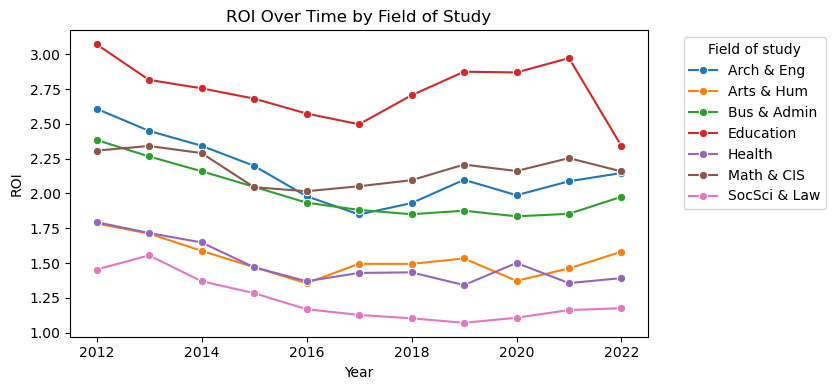

In [24]:
plots.plot_roi_over_time(data, height=8.5, width=4)

### 3.4. Trend Analysis

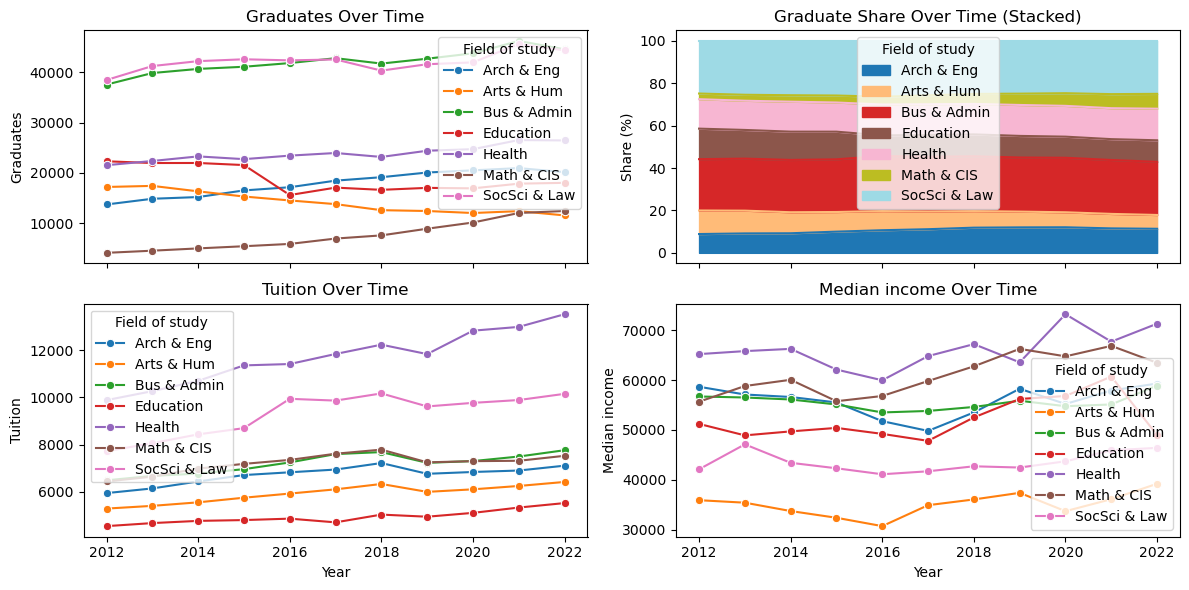

In [25]:
plots.plot_trend_overview(
    data, 
    metrics=["Graduates", "Graduate Share (%)", "Tuition", "Median income"], 
    stacked_metrics=["Graduate Share (%)"],
    height=3, width=6
)

### 3.5. Market Fit
This section assesses how well undergraduate programs align with job market demand. Using metrics like the Saturation Index and Employment Stability Index, we identify fields that may be oversupplied or offer more stable employment—helping students make informed choices and guiding policy alignment.

Metrics are averaged over the three most recent years (2020–2022) to reflect current trends while minimizing short-term fluctuations.

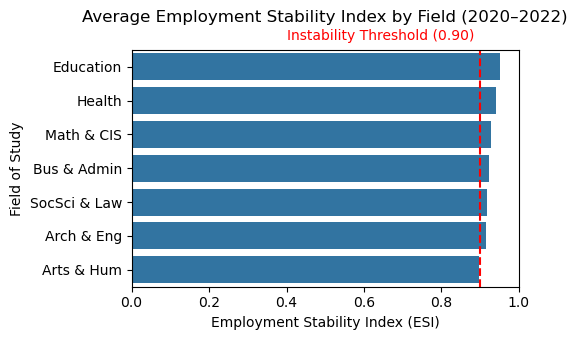

In [26]:
plots.plot_esi_by_field(data, height=3.5, width=5.5, num_years=3)

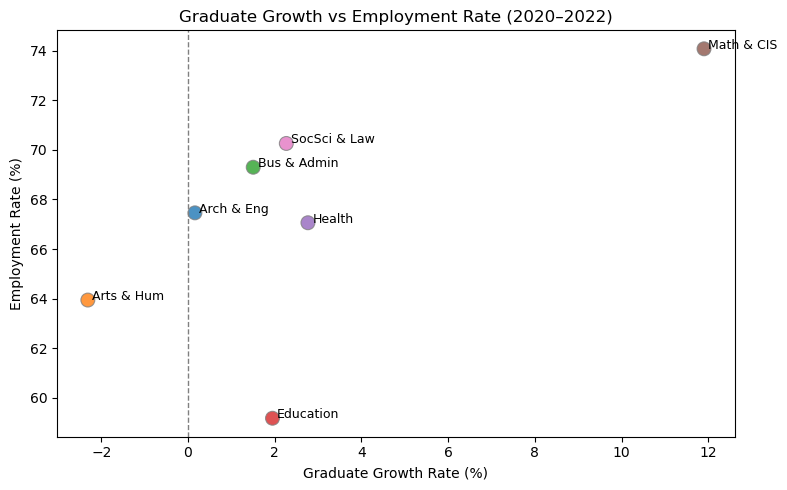

In [27]:
plots.plot_grad_growth_vs_employment(data, height=5, num_years=3)

### 3.6. Correlation & Drivers

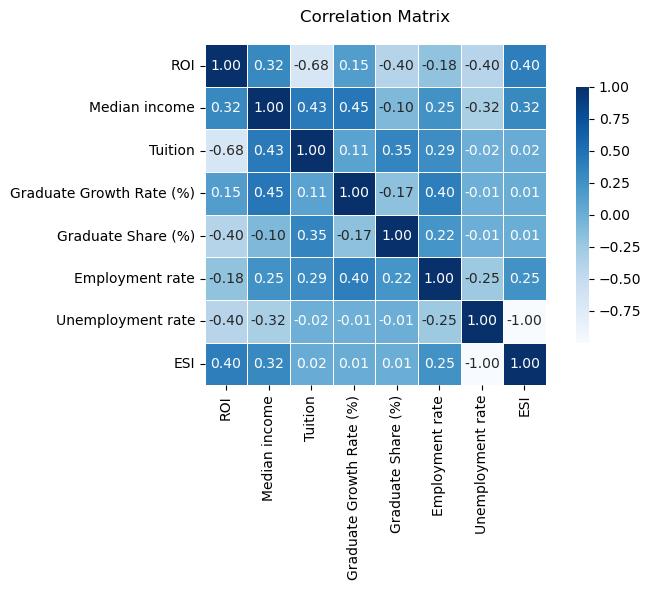

In [32]:
plots.plot_correlation_heatmap(
    data, 
    metrics=["ROI", "Median income", "Tuition", "Graduate Growth Rate (%)", "Graduate Share (%)", "Employment rate", "Unemployment rate", "ESI"]
)